In [1]:
# Importing Necesaary Library
import scipy.io
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
import timeit
from sklearn.metrics import confusion_matrix
import math

Loading CT Scans

In [2]:
data = scipy.io.loadmat("/home/ujjawal/CourseWork/AIMIA/Assignment/Ass1/ctscan_hw1.mat")
temp_ct_scans = data['ctscan']
ct_scans = []
for i in range(temp_ct_scans.shape[2]):
  ct_scans.append(temp_ct_scans[:,:,i])
ct_scans = np.array(ct_scans)
print(ct_scans.shape)

(3554, 512, 512)


Loading Infection Masks

In [3]:
data = scipy.io.loadmat("/home/ujjawal/CourseWork/AIMIA/Assignment/Ass1/infmsk_hw1.mat")
infmask = data['infmsk']
infection_masks = []
for i in range(infmask.shape[2]):
  infection_masks.append(infmask[:,:,i])
infection_masks = np.array(infection_masks)
print(infection_masks.shape)

N = ct_scans.shape[0]

(3554, 512, 512)


Manual Centroid Initialization; DOESN'T WORK

In [4]:
# def find_centroids(temp_ct_scan, temp_inf_mask):
#   b = None
#   i = None
#   h = None
#   for i in range(512):
#     for j in range(512):
#       # if(not (b == None or i == None or h == None) ):
#       #   break
#       if(temp_inf_mask[i][j] == 0):
#         b = temp_ct_scan[i][j]
#       if(temp_inf_mask[i][j] == 1):
#         i = temp_ct_scan[i][j]
#       else:
#         h = temp_ct_scan[i][j]
#   return np.array([b,h,i]).reshape(3,1)

Functions to correct predicted mask, i.e., correct background, infection and healthy region as expected

In [5]:
def find_counts(mask):
  count_background = np.count_nonzero(mask == 0)
  count_infection = np.count_nonzero(mask == 1)
  count_healthy = np.count_nonzero(mask == 2)
  return np.array([count_background, count_infection, count_healthy])

def check_pred_mask(pred_mask):
  pred_count_list = find_counts(pred_mask)
  original_count_list = np.array([100,10,50])
  mapping = dict({})

  for i in range(3):
    pred_max_idx = np.argmax(pred_count_list)
    original_max_idx = np.argmax(original_count_list)
    mapping[pred_max_idx] = original_max_idx
    pred_count_list[pred_max_idx] = -1
    original_count_list[original_max_idx] = -1

  corrected_mask = np.empty(shape=(512,512), dtype=int)
  for i in range(512):
    for j in range(512):
      corrected_mask[i][j] = mapping[pred_mask[i][j]]

  return corrected_mask

Using k-means for Image Segmentation

In [6]:
def get_predicted_mask(ct_scans):
  start = timeit.default_timer()

  pred_masks = []
  for i in range(500):
    sys.stdout.write('\r'+"Processing Image "+str(i))
    sample = ct_scans[i]
    kmeans_obj = KMeans(n_clusters=3, random_state=0)
    ct_scan_flattened = sample.flatten().reshape((512*512,1))
    clusters = kmeans_obj.fit_predict(ct_scan_flattened)
    curr_pred_mask = clusters.reshape((512,512))
    curr_pred_mask = check_pred_mask(curr_pred_mask)
    pred_masks.append(curr_pred_mask)

  pred_masks = np.array(pred_masks)
  print('\n', pred_masks.shape)

  stop = timeit.default_timer()
  print('Time Taken = ', stop - start) 
  
  return pred_masks

In [7]:
pred_masks = get_predicted_mask(ct_scans)

Processing Image 499
 (500, 512, 512)
Time Taken =  229.43128429399803


Checking the Predicted Mask with the expert annotations

In [8]:
# for i in range(n_subset):
#   f, axarr = plt.subplots(1,3)
#   axarr[0].set_title("Expert Annotations")
#   axarr[0].imshow(infection_masks[i])
#   axarr[1].set_title("Predicted Masks")
#   axarr[1].imshow(pred_masks[i])
#   axarr[2].set_title("CT Scans")
#   axarr[2].imshow(ct_scans[i])
#   plt.show()

Two Samples with Expert Annotations(left), Predicted Mask(middle) and CT Scans(right)

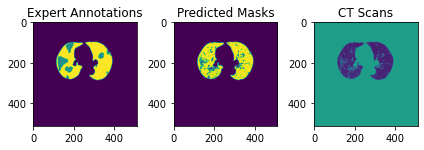

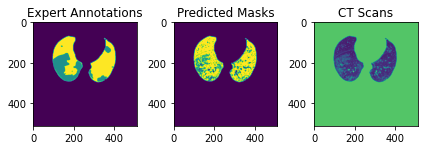

In [9]:
i = 150
f, axarr = plt.subplots(1,3)
axarr[0].set_title("Expert Annotations")
axarr[0].imshow(infection_masks[i])
axarr[1].set_title("Predicted Masks")
axarr[1].imshow(pred_masks[i])
axarr[2].set_title("CT Scans")
axarr[2].imshow(ct_scans[i])
f.tight_layout()
plt.show()

i = 69
f, axarr = plt.subplots(1,3)
axarr[0].set_title("Expert Annotations")
axarr[0].imshow(infection_masks[i])
axarr[1].set_title("Predicted Masks")
axarr[1].imshow(pred_masks[i])
axarr[2].set_title("CT Scans")
axarr[2].imshow(ct_scans[i])
f.tight_layout()
plt.show()

In [11]:
# Pixel Accuracy(Not Required), Not DICE_SCORE
pixel_accuracy = []
for i in range(len(pred_masks)):
  pred_mask = pred_masks[i]
  original_mask = infection_masks[i]
  pixel_accuracy.append((pred_mask == original_mask).sum()/ (512*512))

pixel_accuracy = np.array(pixel_accuracy)
print("Average Pixel Accuracy = ", np.mean(pixel_accuracy))

Average Pixel Accuracy =  0.983642677307129


Evaluating the model performance using several evaluation metrics

In [ ]:
def get_confusion_metric(true_y, pred_y):
  true_y = true_y.flatten()
  pred_y = pred_y.flatten()
  return confusion_matrix(true_y, pred_y,labels=[0,1,2])
  
def get_req_avg_eval_metrics(infection_masks, pred_masks, N):

  # Dice Score is same as F1-Score, NO!
  N = n_subset
  avg_infection_sensitivity = 0
  avg_infection_specificity = 0
  avg_infection_accuracy = 0
  avg_infection_dice_score = 0
  
  avg_healthy_sensitivity = 0
  avg_healthy_specificity = 0
  avg_healthy_accuracy = 0
  avg_healthy_dice_score = 0

  count_infection_sensitivity = 0               # nan error

  for i in range(N):
    
    curr_confusion_metric = (get_confusion_metric(infection_masks[i],pred_masks[i])).T

    infection_TP = curr_confusion_metric[1][1]
    infection_TN = curr_confusion_metric[0][0] + curr_confusion_metric[2][0] + curr_confusion_metric[0][2] + curr_confusion_metric[2][2]
    infection_FP = curr_confusion_metric[1][0] + curr_confusion_metric[1][2] 
    infection_FN = curr_confusion_metric[0][1] + curr_confusion_metric[2][1]

    healthy_TP = curr_confusion_metric[2][2]
    healthy_TN = curr_confusion_metric[0][0] + curr_confusion_metric[0][1] + curr_confusion_metric[1][0] + curr_confusion_metric[1][1]
    healthy_FP = curr_confusion_metric[2][0] + curr_confusion_metric[2][1] 
    healthy_FN = curr_confusion_metric[0][2] + curr_confusion_metric[1][2]

    # Sensitivity = Recall = TP/(TP+FN)
    # Preicision = TP/(TP+FP)
    # Specificity = TN/(TN+FP)
    # Dice Score = 2.TP / (2.TP + FP + FN)

    infection_sensitivity = 0
    if((infection_TP+infection_FN)!=0):
      count_infection_sensitivity += 1
      infection_sensitivity = (infection_TP)/(infection_TP+infection_FN)
        
    infection_specificity = (infection_TN)/(infection_TN+infection_FP)
    infection_accuracy = (infection_TP+infection_TN)/(infection_TP+infection_TN+infection_FP+infection_FN)
    infection_dice_score = (2*infection_TP)/(2*infection_TP + infection_FP + infection_FN)

    healthy_sensitivity = (healthy_TP)/(healthy_TP+healthy_FN)
    healthy_specificity = (healthy_TN)/(healthy_TN+healthy_FP)
    healthy_accuracy = (healthy_TP+healthy_TN)/(healthy_TP+healthy_TN+healthy_FP+healthy_FN)
    healthy_dice_score = (2*healthy_TP)/(2*healthy_TP + healthy_FP + healthy_FN)

    avg_infection_sensitivity += infection_sensitivity
    avg_infection_specificity += infection_specificity
    avg_infection_accuracy += infection_accuracy
    avg_infection_dice_score += infection_dice_score

    avg_healthy_sensitivity += healthy_sensitivity
    avg_healthy_specificity += healthy_specificity
    avg_healthy_accuracy += healthy_accuracy
    avg_healthy_dice_score += healthy_dice_score

  avg_infection_sensitivity = avg_infection_sensitivity/count_infection_sensitivity
  avg_infection_specificity = avg_infection_specificity/N
  avg_infection_accuracy = avg_infection_accuracy/N
  avg_infection_dice_score = avg_infection_dice_score/N

  avg_healthy_sensitivity = avg_healthy_sensitivity/N
  avg_healthy_specificity = avg_healthy_specificity/N
  avg_healthy_accuracy = avg_healthy_accuracy/N
  avg_healthy_dice_score = avg_healthy_dice_score/N

  return avg_infection_dice_score, avg_infection_sensitivity, avg_infection_specificity, avg_infection_accuracy, avg_healthy_dice_score, avg_healthy_sensitivity, avg_healthy_specificity, avg_healthy_accuracy

In [ ]:
inf_ds, inf_sen, inf_spec, inf_acc, hea_ds, hea_sen, hea_spec, hea_acc = get_req_avg_eval_metrics(infection_masks, pred_masks, N)
print("Average Dice Score for Infection: ", inf_ds)
print("Average Sensitivity for Infection: ", inf_sen)
print("Average Specificity for Infection: ", inf_spec)
print("Average Accuracy for Infection: ", inf_acc)
print()
print("Average Dice Score for Healthy: ", hea_ds)
print("Average Sensitivity for Healthy: ", hea_sen)
print("Average Specificity for Healthy: ", hea_spec)
print("Average Accuracy for Healthy: ", hea_acc)